In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt

Data-reuploading classifier
===========================

*Author: Shahnawaz Ahmed (<shahnawaz.ahmed95@gmail.com>). Last updated:
19 Jan 2021.*

A single-qubit quantum circuit which can implement arbitrary unitary
operations can be used as a universal classifier much like a single
hidden-layered Neural Network. As surprising as it sounds,
[Pérez-Salinas et al. (2019)](https://arxiv.org/abs/1907.02085) discuss
this with their idea of 'data reuploading'. It is possible to load a
single qubit with arbitrary dimensional data and then use it as a
universal classifier.


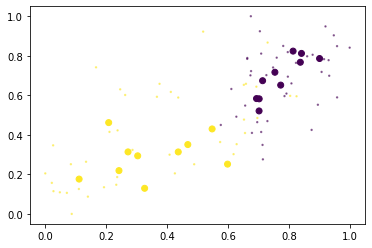

In [25]:
from dataset import read_dataset, divide_dataset, balance_dataset

# read the data
dataset = read_dataset()

# extract a balances subset containing a limited number of points
npts = 100
dataset = balance_dataset(dataset, npts)

# only consider a subset of the features
features = [0,1,2]
nfeatures = len(features)
dataset.features = dataset.features[:,features]

# normalize the data between 0 and 2pi
dataset.features -= dataset.features.min(0)
dataset.features /= dataset.features.max(0)
dataset.features *= 1

# make int labels
dataset.labels = np.array(dataset.labels.astype(int), requires_grad=False)

dataset.features = np.array(dataset.features, requires_grad=False)

# divide the dataset in train/test
train_dataset, test_dataset = divide_dataset(dataset, shuffle=False)

# label
label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

# plot the data
plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,alpha=0.5,s=2)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=test_dataset.labels)

Simple classifier with data reloading and fidelity loss
=======================================================


In [26]:
dev = qml.device("default.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

Utility functions for testing and creating batches
==================================================


In [27]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]
        
# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T

Train a quantum classifier on the circle dataset
================================================


In [28]:
# Generate training and test data
# X_train = np.hstack((train_dataset.features, np.zeros((train_dataset.features.shape[0], 1), requires_grad=False)))
X_train = np.array(train_dataset.features, requires_grad=False)
y_train = train_dataset.labels


# X_test = np.hstack((test_dataset.features, np.zeros((test_dataset.features.shape[0], 1), requires_grad=False)))
X_test = np.array(test_dataset.features, requires_grad=False)
y_test = test_dataset.labels

# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

print(qml.draw(qcircuit)(params, X_train[0], y_train[0]))



 0: ──Rot(0.948, 0.903, 0.0294)──Rot(0.287, 0.436, 0.913)──Rot(0.948, 0.903, 0.0294)──Rot(0.186, 0.182, 0.321)──Rot(0.948, 0.903, 0.0294)──Rot(0.291, 0.25, 0.685)──┤ ⟨H0⟩ 
H0 =
0



In [29]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.471166 | Train accuracy: 0.500000 | Test Accuracy: 0.500000
Epoch:  1 | Loss: 0.240031 | Train accuracy: 0.537500 | Test accuracy: 0.500000
Epoch:  2 | Loss: 0.320815 | Train accuracy: 0.500000 | Test accuracy: 0.500000
Epoch:  3 | Loss: 0.290683 | Train accuracy: 0.500000 | Test accuracy: 0.500000
Epoch:  4 | Loss: 0.199681 | Train accuracy: 0.662500 | Test accuracy: 0.700000
Epoch:  5 | Loss: 0.185363 | Train accuracy: 0.800000 | Test accuracy: 0.950000
Epoch:  6 | Loss: 0.182934 | Train accuracy: 0.762500 | Test accuracy: 0.950000
Epoch:  7 | Loss: 0.162662 | Train accuracy: 0.750000 | Test accuracy: 0.950000
Epoch:  8 | Loss: 0.183974 | Train accuracy: 0.775000 | Test accuracy: 0.750000
Epoch:  9 | Loss: 0.184057 | Train accuracy: 0.762500 | Test accuracy: 0.800000
Epoch: 10 | Loss: 0.169357 | Train accuracy: 0.712500 | Test accuracy: 0.950000


Results
=======


Cost: 0.169357 | Train accuracy 0.712500 | Test Accuracy : 0.950000
Learned weights
Layer 0: [ 0.18259132 -1.11096702  0.86183253]
Layer 1: [0.76377689 2.51429115 0.88799738]
Layer 2: [0.28750166 1.19633581 0.0344055 ]


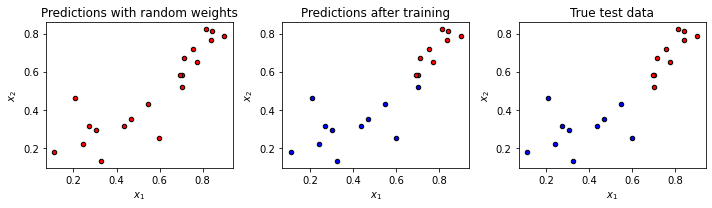

In [31]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

    
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

References
==========

\[1\] Pérez-Salinas, Adrián, et al. "Data re-uploading for a universal
quantum classifier." arXiv preprint arXiv:1907.02085 (2019).

\[2\] Kingma, Diederik P., and Ba, J. "Adam: A method for stochastic
optimization." arXiv preprint arXiv:1412.6980 (2014).

\[3\] Liu, Dong C., and Nocedal, J. "On the limited memory BFGS method
for large scale optimization." Mathematical programming 45.1-3 (1989):
503-528.
